#### Разметка и анализ данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
df_train = pd.read_parquet('train.parquet')
df_test = pd.read_parquet('test.parquet')

In [ ]:
df_train.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


In [ ]:
def draw_time_series(df, index):
  row = df.iloc[index]
  dates = pd.to_datetime(row['dates'])
  values = row['values']

  plt.figure(figsize=(6, 3))
  plt.plot(dates, values, marker='o')
  plt.title(f'Time Series Visualization (ID: {row["id"]})')
  plt.xlabel('Date')
  plt.ylabel('Values')
  plt.grid()
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

#### Временные ряды с label = 0

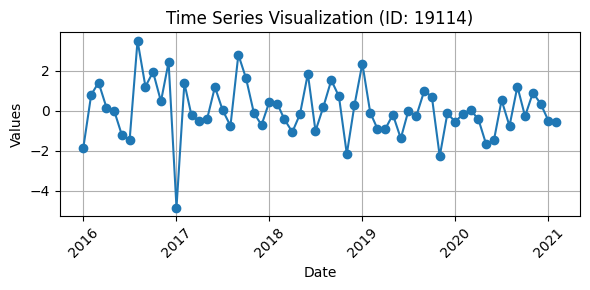

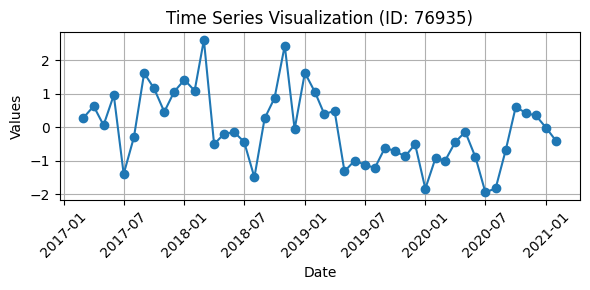

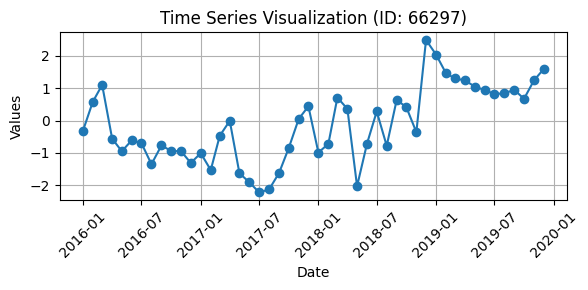

In [ ]:
for i in range(3):
  draw_time_series(df_train[df_train['label'] == 0], i)

#### Временные ряды с label = 1

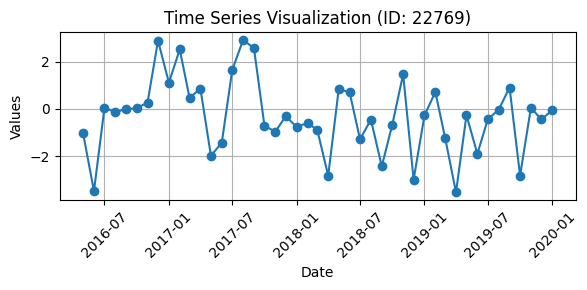

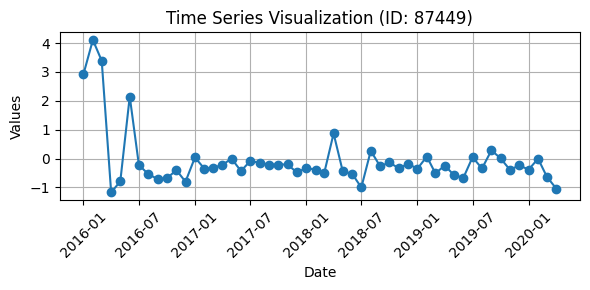

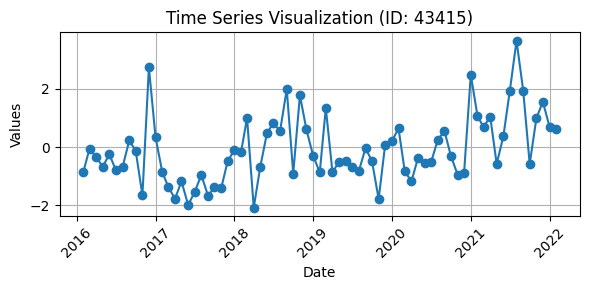

In [ ]:
for i in range(3):
  draw_time_series(df_train[df_train['label'] == 1], i)

#### Сбор признаков

In [ ]:
from scipy.stats import entropy, skew, kurtosis
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
import warnings

def get_features(df, index, test=False):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        row = df.iloc[index]
        dates = pd.to_datetime(row['dates'])
        values = np.nan_to_num(row['values'], nan=0.0)

        # Основные статистические метрики
        variance = np.var(values)
        mean = np.mean(values)
        median = np.median(values)
        skewness = skew(values)
        kurt = kurtosis(values)
        min_value = np.min(values)
        max_value = np.max(values)

        autocorr_lag1 = 0 if len(values) == 0 else np.corrcoef(values[:-1], values[1:])[0, 1]
        grad_mean = np.mean(np.diff(values))
        pos_ratio = 0 if len(values) == 0 else np.sum(values > 0) / len(values)
        neg_ratio = 0 if len(values) == 0 else np.sum(values < 0) / len(values)
        coef_of_variation = 0 if mean == 0 else np.std(values) / mean
        volatility = np.std(np.diff(values))
        max_diff = np.max(np.abs(np.diff(values)))
        diff_variance = np.var(np.diff(values))
        outlier_ratio = np.sum(np.abs(values - mean) > 3 * np.std(values)) / len(values)
        x = np.arange(len(values)).reshape(-1, 1)

        linear_trend = LinearRegression().fit(x, values).coef_[0]
        autocorr_lag12 = 0 if len(values) <= 12 else np.corrcoef(values[:-12], values[12:])[0, 1]
        autocorr_lag6 = 0 if len(values) <= 6 else np.corrcoef(values[:-6], values[6:])[0, 1]
        autocorr_lag3 = 0 if len(values) <= 3 else np.corrcoef(values[:-3], values[3:])[0, 1]
        autocorr_lag9 = 0 if len(values) <= 9 else np.corrcoef(values[:-9], values[9:])[0, 1]

        value_entropy = entropy(np.histogram(values, bins=10, density=True)[0])
        std_skewness = skew(np.diff(values))
        peaks, _ = find_peaks(values)
        peak_count = len(peaks)
        trend_errors = values - (linear_trend * np.arange(len(values)) + mean)
        het = np.var(trend_errors)

        seasonal_sin = np.mean(np.sin(2 * np.pi * np.arange(len(values)) / 12) * values)
        seasonal_cos = np.mean(np.cos(2 * np.pi * np.arange(len(values)) / 12) * values)
        monthly_means = [np.mean(values[i::12]) for i in range(12)]
        monthly_vars = [np.var(values[i::12]) for i in range(12)]
        seasonal_var = np.mean(monthly_vars)
        seasonal_mean = np.mean(monthly_means)
        seasonal_cv = 0 if seasonal_mean == 0 else np.std(monthly_means) / seasonal_mean
        seasonality_index = np.abs(np.mean(monthly_means) - np.median(monthly_means))

        return {
            'id': row['id'],
            'variance': variance,
            'mean': mean,
            'median': median,
            'skewness': skewness,
            'kurtosis': kurt,
            'min': min_value,
            'max': max_value,
            'autocorr_lag1': autocorr_lag1,
            'grad_mean': grad_mean,
            'pos_ratio': pos_ratio,
            'neg_ratio': neg_ratio,
            'coef_of_variation': coef_of_variation,
            'volatility': volatility,
            'max_diff': max_diff,
            'diff_variance': diff_variance,
            'outlier_ratio': outlier_ratio,
            'linear_trend': linear_trend,
            'entropy': value_entropy,
            'std_skewness': std_skewness,
            'peak_count': peak_count,
            'het': het,
            'autocorr_lag3': autocorr_lag3,
            'autocorr_lag6': autocorr_lag6,
            'autocorr_lag9': autocorr_lag9,
            'autocorr_lag12': autocorr_lag12,
            'seasonal_sin': seasonal_sin,
            'seasonal_cos': seasonal_cos,
            'seasonal_var': seasonal_var,
            'seasonal_mean': seasonal_mean,
            'seasonal_cv': seasonal_cv,
            'seasonality_index': seasonality_index,
            'label': -1 if test else row['label']
        }

In [ ]:
from tqdm import tqdm

tqdm.pandas()

df_train_features = pd.DataFrame([get_features(df_train, i) for i in tqdm(range(len(df_train)))])

100%|██████████| 80000/80000 [09:26<00:00, 141.27it/s]


In [ ]:
df_train_features = df_train_features.fillna(0)

In [ ]:
df_train_features.head()

,id,variance,mean,median,skewness,kurtosis,min,max,autocorr_lag1,grad_mean,...,autocorr_lag6,autocorr_lag9,autocorr_lag12,seasonal_sin,seasonal_cos,seasonal_var,seasonal_mean,seasonal_cv,seasonality_index,label
0,19114,1.788298,0.023710,-0.110000,-0.304166,1.889654,-4.840000,3.49,-0.113649,0.021148,...,0.050739,0.002896,0.280619,-0.247905,-0.075403,1.288647,0.033639,20.124245,0.155639,0.0
1,22769,2.422185,-0.310777,-0.274409,-0.011952,-0.107257,-3.534409,2.92,0.189858,0.022400,...,0.148423,0.134247,-0.045302,-0.000334,-0.229489,1.847737,-0.322695,-2.449156,0.212292,1.0
2,76935,1.134274,-0.046042,-0.145000,0.377148,-0.272738,-1.950000,2.61,0.501409,-0.014894,...,0.086759,0.125244,0.230129,-0.300316,0.126538,0.774932,-0.046042,-13.019762,0.219792,0.0
3,66297,1.341429,-0.130000,-0.345000,0.112395,-0.849629,-2.220000,2.49,0.705215,0.040851,...,0.413888,0.388639,0.325891,0.010592,0.261731,1.084716,-0.130000,-3.897454,0.005000,0.0
4,2191,1.614244,-0.270536,-0.475000,0.398655,-0.587199,-2.500000,2.87,0.088913,-0.037455,...,-0.089293,0.026169,0.582828,0.176279,0.329066,0.526813,-0.284667,-3.564434,0.326333,0.0


In [ ]:
X = df_train_features.drop(columns=['label'])
y = df_train_features['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def count_and_visualise_roc_auc(model_name, X_train, y_train, X_val, y_val, model):
  for name, X, y, model in [
      ('train', X_train, y_train, model),
      ('val ', X_val, y_val, model)
  ]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

  plt.plot([0, 1], [0, 1], '--', color='black',)
  plt.legend(fontsize='large')
  plt.grid()

  val_accuracy = np.mean(model.predict(X_val) == y_val)
  print(f"{model_name} accuracy: {val_accuracy:.3f}")

Далее я создаю несколько моделей, которые далее будут также использоваться в стекинге

### Random Forest

In [ ]:
forest_model = RandomForestClassifier(random_state=42, max_depth=13, min_samples_split=3, n_estimators=200)
forest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, min_samples_split=3, n_estimators=200,
                       random_state=42)

Forest model accuracy: 0.840


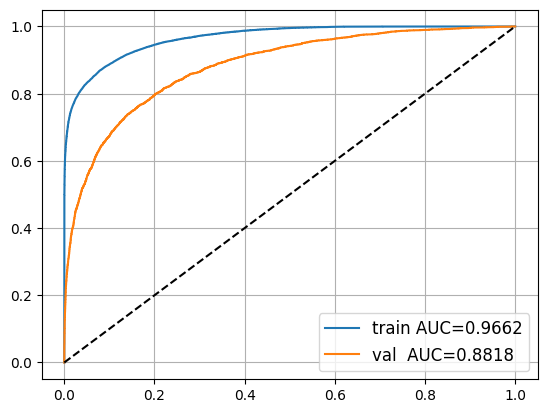

In [ ]:
count_and_visualise_roc_auc("Forest model", X_train, y_train, X_val, y_val, forest_model)

### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42, n_estimators=1000, max_depth=4, learning_rate=0.2)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

XGBoosting Model (4 deep) accuracy: 0.840


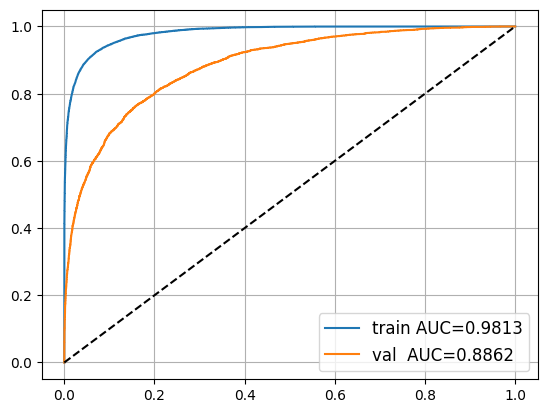

In [ ]:
count_and_visualise_roc_auc("XGBoosting Model (4 deep)", X_train, y_train, X_val, y_val, xgb_model)

### CatBoost

In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(iterations=800, depth=4, random_seed=42, verbose=0)
catboost_model.fit(X_train, y_train)

CatBoost model accuracy: 0.851


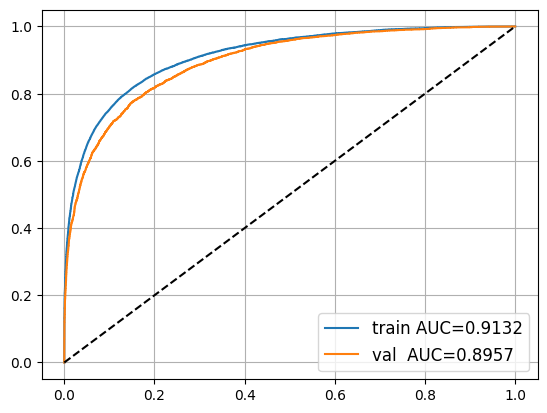

In [ ]:
count_and_visualise_roc_auc("CatBoost model", X_train, y_train, X_val, y_val, catboost_model)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

logistic_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000, random_state=42, C=0.01))
logistic_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.01, max_iter=10000, random_state=42))])

logistic model accuracy: 0.831


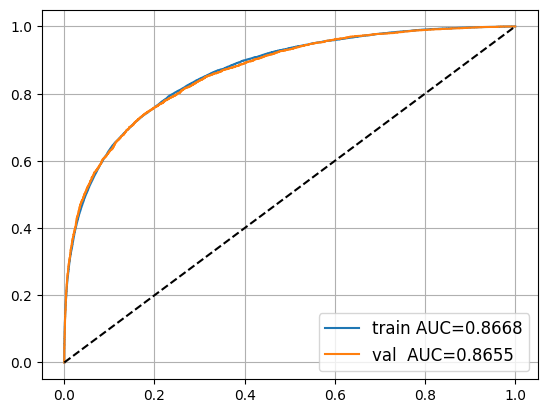

In [ ]:
count_and_visualise_roc_auc("logistic model", X_train, y_train, X_val, y_val, logistic_model)

### Stacking (Итоговая модель)

In [ ]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('forest', forest_model),
    ('logistic', logistic_model),
    ('xgb', xgb_model),
    ('catboost', catboost_model)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=10000, random_state=42, C=0.1)
)
stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('forest',
                                RandomForestClassifier(max_depth=13,
                                                       min_samples_split=3,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('logistic',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('logisticregression',
                                                 LogisticRegression(C=0.01,
                                                                    max_iter=10000,
                                                                    random_state=42))])),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsa...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=4,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=1000, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x796509b4e5f0>)],
                   final_estimator=LogisticRegression(C=0.1, max_iter=10000,
                                                      random_state=42))

stacking model accuracy: 0.850


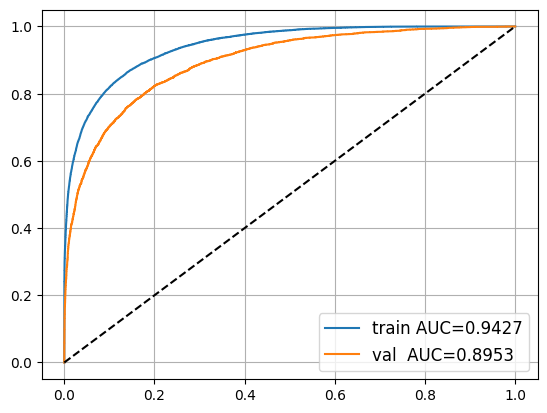

In [ ]:
count_and_visualise_roc_auc("stacking model", X_train, y_train, X_val, y_val, stacking_model)

In [ ]:
from joblib import dump

best_model = stacking_model
dump(best_model, open('best_model.sav', 'wb'))

### Запуск на тестовых данных и сохранение файлов

In [ ]:
df_test_features = pd.DataFrame([get_features(df_test, i, test=True) for i in range(len(df_test))])
df_test_features = df_test_features.fillna(0).drop(columns=['label'])

In [ ]:
df_test_features.head()

,id,variance,mean,median,skewness,kurtosis,min,max,autocorr_lag1,grad_mean,...,autocorr_lag3,autocorr_lag6,autocorr_lag9,autocorr_lag12,seasonal_sin,seasonal_cos,seasonal_var,seasonal_mean,seasonal_cv,seasonality_index
0,6125,2.267992,0.037895,-0.01,0.066034,-0.416815,-3.14,3.13,0.361637,-0.037857,...,0.103024,-0.425740,-0.076997,0.482887,-0.089486,0.713990,0.914516,0.078500,14.703633,0.117250
1,26781,1.561658,-0.016909,-0.08,0.874569,0.857138,-2.24,3.85,0.013262,0.051667,...,-0.058569,-0.029267,-0.191265,0.011299,-0.221497,0.069420,1.183818,0.009542,65.406094,0.046708
2,13333,1.001027,-0.039569,-0.16,0.963947,1.074141,-1.45,3.46,0.376190,0.031071,...,0.133976,-0.144913,0.073702,0.376320,-0.188892,-0.259557,0.678895,-0.017192,-33.091082,0.025551
3,53218,1.724264,0.159231,0.11,0.384563,-0.054884,-2.73,3.43,0.260440,0.010260,...,0.131722,-0.102478,0.053970,0.194035,0.026502,-0.378837,1.181783,0.171111,4.277508,0.258492
4,84204,1.545744,-0.094705,-0.09,-0.032288,-0.534065,-2.66,2.57,0.358273,-0.059802,...,0.307325,-0.006650,-0.259001,-0.358682,-0.033210,0.099769,1.409767,-0.097718,-3.803315,0.060892


In [ ]:
df_test_features.to_parquet('df_test_features.parquet', index=False)

In [ ]:
predictions = best_model.predict(df_test_features)

In [157]:
submission = pd.DataFrame({
    'id': df_test_features['id'],
    'prediction': predictions
})

submission.head(5)
submission.to_csv('submission.csv', index=False)